In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Make pandas show more columns
pd.set_option("display.max_columns", 50)

# === Load data (change paths if needed) ===
matches = pd.read_csv("/Users/arpit/Desktop/IPL/matches.csv")
deliveries = pd.read_csv("/Users/arpit/Desktop/IPL/deliveries.csv")

matches.head(), deliveries.head()


(    season                                       venue                  event  \
 0  2007/08                       M Chinnaswamy Stadium  Indian Premier League   
 1  2007/08  Punjab Cricket Association Stadium, Mohali  Indian Premier League   
 2  2007/08                            Feroz Shah Kotla  Indian Premier League   
 3  2007/08                                Eden Gardens  Indian Premier League   
 4  2007/08                            Wankhede Stadium  Indian Premier League   
 
    winner_runs         umpire2                  toss_winner        date  \
 0        140.0     RE Koertzen  Royal Challengers Bangalore  2008-04-18   
 1         33.0      SL Shastri          Chennai Super Kings  2008-04-19   
 2          NaN  GA Pratapkumar             Rajasthan Royals  2008-04-19   
 3          NaN     K Hariharan              Deccan Chargers  2008-04-20   
 4          NaN       DJ Harper               Mumbai Indians  2008-04-20   
 
   neutralvenue    umpire1        city reserve_u

In [2]:
# Select useful columns from matches
match_cols = [
    "matchId", "season", "venue", "city",
    "team1", "team2", "toss_winner", "toss_decision", "winner"
]

matches_small = matches[match_cols].copy()

# Merge on matchId
data = deliveries.merge(matches_small, on="matchId", how="left")

print(data.shape)
data.head()


(278205, 28)


,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,date,season,venue,city,team1,team2,toss_winner,toss_decision,winner
0,335982,1,0.1,0,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2008-04-18,2007/08,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders
1,335982,1,0.2,0,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,2007/08,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders
2,335982,1,0.3,0,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,2007/08,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders
3,335982,1,0.4,0,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,2007/08,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders
4,335982,1,0.5,0,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-04-18,2007/08,M Chinnaswamy Stadium,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders


In [3]:
# Helper: is this ball a wicket?
data["is_wicket"] = data["dismissal_kind"].notna().astype(int)

# Total runs on this ball (batsman + extras)
data["total_runs_ball"] = data["batsman_runs"] + data["extras"]

# Define outcome for each ball
def get_outcome(row):
    # Wicket overrides everything
    if row["is_wicket"] == 1:
        return "wicket"
    
    # Wides / no-balls / byes / leg-byes / penalty counted as extras
    if (row["isWide"] == 1) or (row["isNoBall"] == 1) or \
       (row["Byes"] > 0) or (row["LegByes"] > 0) or (row["Penalty"] > 0):
        return "extra"
    
    r = row["batsman_runs"]
    if r in [0, 1, 2, 3, 4, 6]:
        return str(int(r))
    
    # Rare things like 5 runs → treat as extra
    return "extra"

data["outcome"] = data.apply(get_outcome, axis=1)

data["outcome"].value_counts()


outcome
1         102432
0          83202
4          31971
2          17347
extra      14364
6          14256
wicket     13823
3            810
Name: count, dtype: int64

In [4]:
# Sort by match → inning → over → ball
data = data.sort_values(["matchId", "inning", "over", "ball"]).reset_index(drop=True)

# Within each match+inning, compute cumulative stats and then shift by 1 to get "state before ball"
group_cols = ["matchId", "inning"]

data["cum_runs"] = data.groupby(group_cols)["total_runs_ball"].cumsum()
data["cum_wkts"] = data.groupby(group_cols)["is_wicket"].cumsum()

# State BEFORE this ball
data["runs_before"] = data.groupby(group_cols)["cum_runs"].shift(1).fillna(0)
data["wkts_before"] = data.groupby(group_cols)["cum_wkts"].shift(1).fillna(0)

# Balls number in innings (1..120) then "balls_before"
data["ball_number"] = ((data["over"] - 1) * 6 + data["ball"]).astype(int)
data["balls_before"] = data.groupby(group_cols)["ball_number"].shift(1).fillna(0)

# Run rate before this ball (avoid divide by zero)
data["run_rate_before"] = np.where(
    data["balls_before"] > 0,
    data["runs_before"] * 6.0 / data["balls_before"],
    0.0
)

# Game phase flags
data["is_powerplay"] = (data["over"] <= 6).astype(int)
data["is_middle"] = ((data["over"] > 6) & (data["over"] <= 15)).astype(int)
data["is_death"] = (data["over"] >= 16).astype(int)

data[[
    "matchId", "inning", "over", "ball",
    "runs_before", "wkts_before", "balls_before",
    "run_rate_before", "is_powerplay", "is_death",
    "outcome"
]].head(15)


,matchId,inning,over,ball,runs_before,wkts_before,balls_before,run_rate_before,is_powerplay,is_death,outcome
0,335982,1,0,1,0.0,0.0,0.0,0.0,1,0,extra
1,335982,1,0,2,1.0,0.0,-5.0,0.0,1,0,0
2,335982,1,0,3,1.0,0.0,-4.0,0.0,1,0,extra
3,335982,1,0,4,2.0,0.0,-3.0,0.0,1,0,0
4,335982,1,0,5,2.0,0.0,-2.0,0.0,1,0,0
5,335982,1,0,6,2.0,0.0,-1.0,0.0,1,0,0
6,335982,1,0,7,2.0,0.0,0.0,0.0,1,0,extra
7,335982,1,1,1,3.0,0.0,1.0,18.0,1,0,0
8,335982,1,1,2,3.0,0.0,1.0,18.0,1,0,4
9,335982,1,1,3,7.0,0.0,2.0,21.0,1,0,4


In [5]:
# Some seasons like "2007/08" – take first 4 digits
def season_to_int(s):
    s = str(s)
    return int(s[:4])

data["season_int"] = data["season"].apply(season_to_int)

data["season_int"].value_counts().sort_index()


season_int
2007    13489
2009    28104
2011    17013
2012    17767
2013    18177
2014    14300
2015    13652
2016    14096
2017    13862
2018    14286
2019    14312
2020    14559
2021    14425
2022    17912
2023    17863
2024    17103
2025    17285
Name: count, dtype: int64

In [6]:
# Drop rows with missing key info
data_model = data.dropna(subset=["batting_team", "bowling_team", "batsman", "bowler", "venue", "city", "outcome"]).copy()

feature_cols_num = [
    "inning", "over", "ball",
    "runs_before", "wkts_before",
    "balls_before", "run_rate_before",
    "is_powerplay", "is_middle", "is_death",
    "season_int"
]

feature_cols_cat = [
    "batting_team", "bowling_team",
    "batsman", "bowler",
    "venue", "city"
]

target_col = "outcome"

# Make a copy for encoding
df = data_model[feature_cols_num + feature_cols_cat + [target_col, "season_int"]].copy()

# Label encode all categoricals
encoders = {}
for col in feature_cols_cat + [target_col]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

df.head()


,inning,over,ball,runs_before,wkts_before,balls_before,run_rate_before,is_powerplay,is_middle,is_death,season_int,batting_team,bowling_team,batsman,bowler,venue,city,outcome,season_int
0,1,0,1,0.0,0.0,0.0,0.0,1,0,0,2007,8,16,561,344,23,2,6,2007
1,1,0,2,1.0,0.0,-5.0,0.0,1,0,0,2007,8,16,104,344,23,2,0,2007
2,1,0,3,1.0,0.0,-4.0,0.0,1,0,0,2007,8,16,104,344,23,2,6,2007
3,1,0,4,2.0,0.0,-3.0,0.0,1,0,0,2007,8,16,104,344,23,2,0,2007
4,1,0,5,2.0,0.0,-2.0,0.0,1,0,0,2007,8,16,104,344,23,2,0,2007


In [21]:
# ================================
# FINAL TRAIN/TEST SPLIT (WORKING)
# ================================

cutoff_year = 2019  # Train on <2019, Test on >=2019

train_mask = df["season_int"] < cutoff_year
test_mask  = df["season_int"] >= cutoff_year

print("Train rows:", train_mask.sum())
print("Test rows :", test_mask.sum())

# Build features X and target y
X = df[feature_cols_num + feature_cols_cat].copy()
y = df[target_col].copy()

# Apply masks correctly
X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()

y_train = y.loc[train_mask].copy()
y_test  = y[test_mask].copy()

print("\nShapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


Train rows: 161607
Test rows : 104201

Shapes:
X_train: (161607, 17)
X_test : (104201, 17)
y_train: (161607,)
y_test : (104201,)


In [22]:
# ================================
# STEP 8 — Train XGBoost Model
# ================================

# Install XGBoost if needed:
# !pip install xgboost

from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.10,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist"   # FAST + GOOD
)

print("Training XGBoost... (may take 1–3 minutes)")
model.fit(X_train, y_train)

print("Training complete!")


Training XGBoost... (may take 1–3 minutes)
Training complete!


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.39      0.39      0.39     29812
           1       0.41      0.77      0.53     38392
           2       0.14      0.00      0.01      6240
           3       0.00      0.00      0.00       240
           4       0.17      0.01      0.03     12397
           6       0.14      0.01      0.02      6385
       extra       0.14      0.00      0.01      5516
      wicket       0.12      0.02      0.04      5219

    accuracy                           0.40    104201
   macro avg       0.19      0.15      0.13    104201
weighted avg       0.31      0.40      0.31    104201



/Users/arpit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arpit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arpit/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

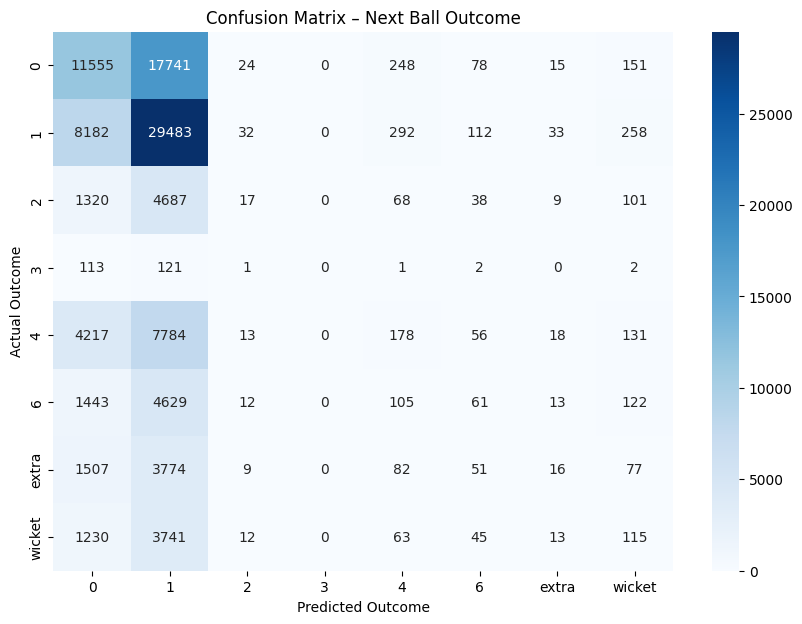

In [23]:
# ================================
# STEP 9 — Evaluate Model
# ================================

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Classification report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=encoders[target_col].classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoders[target_col].classes_,
    yticklabels=encoders[target_col].classes_
)
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix – Next Ball Outcome")
plt.show()


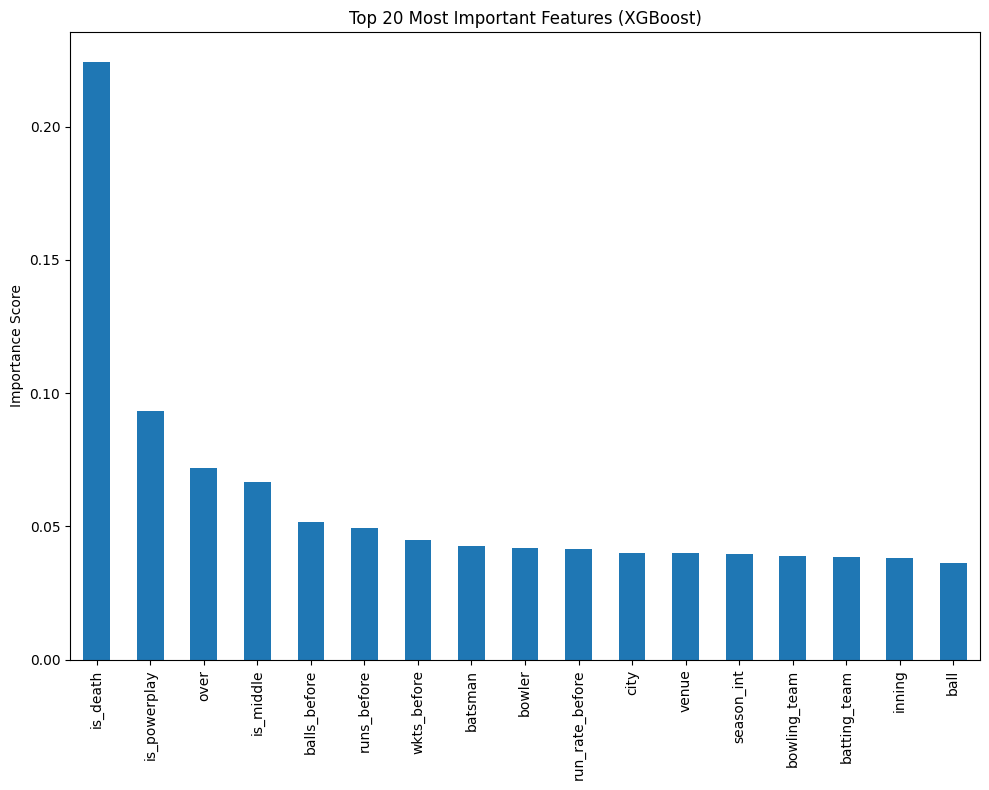

is_death           0.224113
is_powerplay       0.093412
over               0.071887
is_middle          0.066534
balls_before       0.051588
runs_before        0.049419
wkts_before        0.045105
batsman            0.042589
bowler             0.041949
run_rate_before    0.041694
city               0.040051
venue              0.040003
season_int         0.039733
bowling_team       0.038771
batting_team       0.038676
inning             0.038172
ball               0.036304
dtype: float32

In [24]:
# ================================
# STEP 10 — Feature Importances
# ================================

import pandas as pd
import matplotlib.pyplot as plt

# XGBoost feature importances
importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,8))
feat_imp.head(20).plot(kind="bar")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

feat_imp.head(20)


In [25]:
# ================================
# STEP 11 — Single Ball Probability Prediction
# ================================

import numpy as np

# Pick a random test sample
sample_idx = X_test.sample(1, random_state=42).index[0]

x_sample = X_test.loc[[sample_idx]]
y_true_encoded = y_test.loc[sample_idx]
true_label = encoders[target_col].inverse_transform([y_true_encoded])[0]

# Predict probabilities
probs = model.predict_proba(x_sample)[0]
classes_enc = np.arange(len(probs))
classes_lbl = encoders[target_col].inverse_transform(classes_enc)

print("=== Actual Outcome ===")
print("Actual:", true_label)
print("\n=== Predicted Probabilities ===")
for cls, p in zip(classes_lbl, probs):
    print(f"{cls:>7}: {p:.3f}")


=== Actual Outcome ===
Actual: 0

=== Predicted Probabilities ===
      0: 0.285
      1: 0.438
      2: 0.053
      3: 0.003
      4: 0.079
      6: 0.044
  extra: 0.038
 wicket: 0.060


In [26]:
# ================================
# STEP 12 — Simulate the Next Over
# ================================

def simulate_over(x_state, model, encoders, balls=6):
    """
    x_state: A single row from X_test (DataFrame with 1 row)
    balls: Number of balls to simulate
    """
    outcome_counts = {cls: 0 for cls in encoders[target_col].classes_}
    simulated_outcomes = []

    for b in range(balls):
        # Predict probabilities
        probs = model.predict_proba(x_state)[0]

        # Encoded class indices
        classes_enc = np.arange(len(probs))
        classes_lbl = encoders[target_col].inverse_transform(classes_enc)

        # Choose outcome randomly based on probability distribution
        chosen_enc = np.random.choice(classes_enc, p=probs)
        chosen_lbl = encoders[target_col].inverse_transform([chosen_enc])[0]

        # Save outcome
        simulated_outcomes.append(chosen_lbl)
        outcome_counts[chosen_lbl] += 1

    return simulated_outcomes, outcome_counts



# ------------------------
# Run Simulation
# ------------------------

example_state = X_test.iloc[[0]]  # any single row from test set

sim_outcomes, sim_counts = simulate_over(example_state, model, encoders, balls=6)

print("=== Simulated Outcomes for Next Over ===")
print(sim_outcomes)

print("\n=== Count of Each Outcome ===")
for outcome, count in sim_counts.items():
    print(f"{outcome:>7}: {count}")


=== Simulated Outcomes for Next Over ===
['1', '0', '0', '0', '0', 'extra']

=== Count of Each Outcome ===
      0: 4
      1: 1
      2: 0
      3: 0
      4: 0
      6: 0
  extra: 1
 wicket: 0


In [27]:
# ================================
# STEP 13 — SCORE PROJECTION ENGINE
# Predict next N balls and return projected score range
# ================================

def update_state(x_state, outcome_lbl):
    """
    Updates the state (DataFrame row) based on predicted outcome.
    """
    x = x_state.copy()

    # Extract features
    runs_before = x.iloc[0]["runs_before"]
    wkts_before = x.iloc[0]["wkts_before"]
    balls_before = x.iloc[0]["balls_before"]

    # Convert outcome to numeric
    if outcome_lbl == "wicket":
        wkts_before += 1
        run_scored = 0
    elif outcome_lbl == "extra":
        run_scored = 1
    else:
        run_scored = int(outcome_lbl)

    # Update runs & balls
    runs_before += run_scored
    balls_before += 1

    # Update over/ball
    over = (balls_before // 6) + 1
    ball = (balls_before % 6)
    if ball == 0:
        ball = 6

    # Powerplay / Middle / Death
    is_powerplay = 1 if over <= 6 else 0
    is_middle = 1 if 7 <= over <= 15 else 0
    is_death = 1 if over >= 16 else 0

    # Updated runrate
    run_rate_before = (runs_before * 6 / balls_before) if balls_before > 0 else 0

    # Update the state in the DataFrame
    x.loc[:, "runs_before"] = runs_before
    x.loc[:, "wkts_before"] = wkts_before
    x.loc[:, "balls_before"] = balls_before
    x.loc[:, "over"] = over
    x.loc[:, "ball"] = ball
    x.loc[:, "run_rate_before"] = run_rate_before
    x.loc[:, "is_powerplay"] = is_powerplay
    x.loc[:, "is_middle"] = is_middle
    x.loc[:, "is_death"] = is_death

    return x


def project_next_balls(x_state, model, encoders, n_balls=30):
    """
    Simulate next n balls and project a score range.
    """
    x = x_state.copy()
    projected_runs = 0
    projected_outcomes = []

    for i in range(n_balls):
        # Predict probabilities
        probs = model.predict_proba(x)[0]
        classes_enc = np.arange(len(probs))
        classes_lbl = encoders[target_col].inverse_transform(classes_enc)

        # Pick an outcome according to probability
        chosen_enc = np.random.choice(classes_enc, p=probs)
        chosen_lbl = encoders[target_col].inverse_transform([chosen_enc])[0]

        projected_outcomes.append(chosen_lbl)

        # Update projected run count
        if chosen_lbl == "wicket":
            pass
        elif chosen_lbl == "extra":
            projected_runs += 1
        else:
            projected_runs += int(chosen_lbl)

        # Update match state for next iteration
        x = update_state(x, chosen_lbl)

    return projected_runs, projected_outcomes


# ==========================
# RUN A 30-BALL PROJECTION
# ==========================

initial_state = X_test.iloc[[0]]

proj_runs, proj_outcomes = project_next_balls(
    initial_state,
    model,
    encoders,
    n_balls=30
)

print("=== Projected Outcomes for Next 30 Balls (5 Overs) ===")
print(proj_outcomes)

print("\nProjected Runs in Next 5 Overs:", proj_runs)


=== Projected Outcomes for Next 30 Balls (5 Overs) ===
['extra', '2', '2', '4', '1', '0', '6', '1', '0', '4', '1', '1', 'extra', '1', '0', '1', '1', '0', '0', '4', '0', '1', '1', '1', '4', '1', '0', '1', '4', '1']

Projected Runs in Next 5 Overs: 45


/var/folders/57/l1m32wzn48d_s4kd5kgj_j_00000gn/T/ipykernel_44693/746852450.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


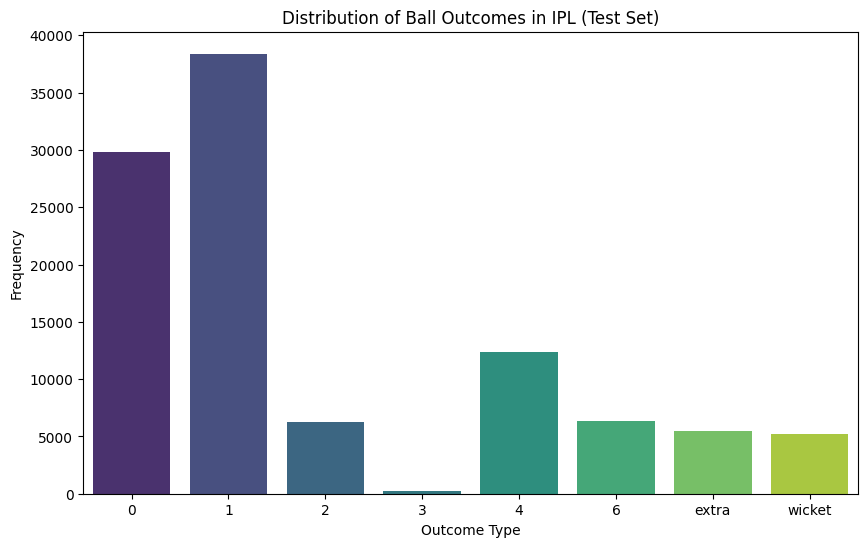

In [29]:
# ================================
# CLASS DISTRIBUTION PLOT
# ================================

import seaborn as sns
import matplotlib.pyplot as plt

y_test_labels = encoders[target_col].inverse_transform(y_test)

plt.figure(figsize=(10,6))
sns.countplot(
    x=y_test_labels,
    order=encoders[target_col].classes_,
    palette="viridis"
)
plt.title("Distribution of Ball Outcomes in IPL (Test Set)")
plt.xlabel("Outcome Type")
plt.ylabel("Frequency")
plt.show()


In [30]:
# ================================
# SIMPLE AI COMMENTARY
# ================================

sample_idx = X_test.sample(1).index[0]
x_sample = X_test.loc[[sample_idx]]

probs = model.predict_proba(x_sample)[0]
classes_lbl = encoders[target_col].inverse_transform(np.arange(len(probs)))

print("=== AI Commentary ===")
for cls, p in sorted(zip(classes_lbl, probs), key=lambda x: -x[1]):
    print(f"Chance of {cls}: {p*100:.1f}%")


=== AI Commentary ===
Chance of wicket: 33.3%
Chance of 0: 26.4%
Chance of 1: 19.0%
Chance of 6: 8.5%
Chance of 4: 7.2%
Chance of extra: 3.4%
Chance of 2: 2.2%
Chance of 3: 0.0%


In [31]:
import pickle

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save encoders
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

# Save X_test
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

# Save target column name
with open("target_col.pkl", "wb") as f:
    pickle.dump(target_col, f)
